# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# GRASP

In [2]:
def calculate_cost_and_feasibility(production, demands, setup_cost, holding_cost, max_inventory):
    inventory = 0
    total_cost = 0
    feasible = True
    for t in range(len(production)):
        if production[t] < 0:
            feasible = False
        inventory += production[t] - demands[t]
        if inventory < 0 or inventory > max_inventory:
            feasible = False
        if production[t] > 0:
            total_cost += setup_cost[t]
        total_cost += holding_cost[t] * max(0, inventory)
    return (total_cost, feasible)

def local_search(initial_solution, demands, setup_cost, holding_cost, max_inventory):
    current_solution = initial_solution.copy()
    current_cost, current_feasible = calculate_cost_and_feasibility(current_solution, demands, setup_cost, holding_cost, max_inventory)
    
    if not current_feasible:
        return initial_solution.copy(), float('inf')
    
    improved = True
    while improved:
        improved = False
        best_neighbor = None
        best_neighbor_cost = current_cost
        
        for i in range(len(current_solution) - 1):
            neighbor1 = current_solution.copy()
            neighbor1[i] += neighbor1[i+1]
            neighbor1[i+1] = 0
            cost1, feasible1 = calculate_cost_and_feasibility(neighbor1, demands, setup_cost, holding_cost, max_inventory)
            
            neighbor2 = current_solution.copy()
            neighbor2[i+1] += neighbor2[i]
            neighbor2[i] = 0
            cost2, feasible2 = calculate_cost_and_feasibility(neighbor2, demands, setup_cost, holding_cost, max_inventory)
            
            if feasible1 and cost1 < best_neighbor_cost:
                best_neighbor = neighbor1
                best_neighbor_cost = cost1
            if feasible2 and cost2 < best_neighbor_cost:
                best_neighbor = neighbor2
                best_neighbor_cost = cost2
        
        if best_neighbor_cost < current_cost:
            current_solution = best_neighbor
            current_cost = best_neighbor_cost
            improved = True
    
    return current_solution, current_cost

def greedy_randomized_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=10):
    n = len(demands)
    best_cost = float('inf')
    best_solution = None
    
    for _ in range(num_iterations):
        inventory = 0
        production = [0] * n
        total_cost = 0
        
        for t in range(n):
            needed = max(0, demands[t] - inventory)
            
            options = []
            if inventory >= demands[t]:
                options.append(0)
            
            options.append(needed)
            max_production = min(sum(demands[t:]), max_inventory - inventory + demands[t])
            if max_production > needed:
                options.append(max_production)
                for _ in range(2):
                    options.append(random.randint(needed, max_production))
            
            costs = []
            for option in options:
                if option > 0:
                    cost = setup_cost[t] + holding_cost[t] * max(0, inventory + option - demands[t])
                else:
                    cost = holding_cost[t] * max(0, inventory - demands[t])
                costs.append(cost)
            
            if not costs:
                continue
            
            # Peso para soluções melhores terem melhor chance de serem escolhidas
            weights = [max(costs) - cost + 1 for cost in costs]
            selected_idx = random.choices(range(len(options)), weights=weights, k=1)[0]
            option = options[selected_idx] 
            
            production[t] = option
            if option > 0:
                total_cost += setup_cost[t]
            inventory += option - demands[t] # Remover a demanda do inventário
            total_cost += holding_cost[t] * max(0, inventory)
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_solution = production.copy()
    
    return best_solution, best_cost

def grasp_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=1000):
    best_cost = float('inf')
    best_solution = None
    for _ in range(num_iterations):
        solution, cost = greedy_randomized_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=1)
        improved_solution, improved_cost = local_search(solution, demands, setup_cost, holding_cost, max_inventory)
        if improved_cost < best_cost:
            best_cost = improved_cost
            best_solution = improved_solution
    return best_solution, best_cost

In [3]:
demands = [5, 3, 7, 1, 2, 3, 8, 3, 3, 4, 9, 1, 1, 2, 5, 9, 9, 1, 5, 6, 1, 7, 2]
setup_cost = [50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50] 
holding_cost = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2] 
max_inventory = 10


solution, cost = grasp_lot_sizing(demands, setup_cost, holding_cost, max_inventory)
print("Melhor plano de produção:", solution)
print("Custo Total:", cost)

Melhor plano de produção: [8, 0, 13, 0, 0, 0, 18, 0, 0, 0, 11, 0, 0, 8, 0, 18, 0, 0, 12, 0, 0, 9, 0]
Custo Total: 538


# GRASP 2 (All pairs)

In [4]:
def calculate_cost_and_feasibility(production, demands, setup_cost, holding_cost, max_inventory):
    inventory = 0
    total_cost = 0
    feasible = True
    for t in range(len(production)):
        if production[t] < 0:
            feasible = False
        inventory += production[t] - demands[t]
        if inventory < 0 or inventory > max_inventory:
            feasible = False
        if production[t] > 0:
            total_cost += setup_cost[t]
        total_cost += holding_cost[t] * max(0, inventory)
    return (total_cost, feasible)

def local_search(initial_solution, demands, setup_cost, holding_cost, max_inventory):
    current_solution = initial_solution.copy()
    current_cost, current_feasible = calculate_cost_and_feasibility(current_solution, demands, setup_cost, holding_cost, max_inventory)
    
    if not current_feasible:
        return initial_solution.copy(), float('inf')
    
    improved = True
    while improved:
        improved = False
        best_neighbor = None
        best_neighbor_cost = current_cost
        
        for i in range(len(current_solution)):
            for j in range(len(current_solution)):
                if i == j:
                    continue
                
                neighbor1 = current_solution.copy()
                neighbor1[i] += neighbor1[j]
                neighbor1[j] = 0
                cost1, feasible1 = calculate_cost_and_feasibility(neighbor1, demands, setup_cost, holding_cost, max_inventory)
                
                neighbor2 = current_solution.copy()
                neighbor2[j] += neighbor2[i]
                neighbor2[i] = 0
                cost2, feasible2 = calculate_cost_and_feasibility(neighbor2, demands, setup_cost, holding_cost, max_inventory)
                
                if feasible1 and cost1 < best_neighbor_cost:
                    best_neighbor = neighbor1
                    best_neighbor_cost = cost1
                if feasible2 and cost2 < best_neighbor_cost:
                    best_neighbor = neighbor2
                    best_neighbor_cost = cost2
        
        if best_neighbor is not None and best_neighbor_cost < current_cost:
            current_solution = best_neighbor
            current_cost = best_neighbor_cost
            print("Melhorou Local: ", current_solution," Custo: ",current_cost)
            improved = True
    
    return current_solution, current_cost

def greedy_randomized_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=10):
    n = len(demands)
    best_cost = float('inf')
    best_solution = None
    
    for _ in range(num_iterations):
        inventory = 0
        production = [0] * n
        total_cost = 0
        
        for t in range(n):
            needed = max(0, demands[t] - inventory)
            
            options = []
            if inventory >= demands[t]:
                options.append(0)
            
            options.append(needed)
            
            max_production = min(sum(demands[t:]), max_inventory - inventory + demands[t])
            if max_production > needed:
                options.append(max_production)
                for _ in range(2):
                    options.append(random.randint(needed, max_production))
            
            costs = []
            for option in options:
                if option > 0:
                    cost = setup_cost[t] + holding_cost[t] * max(0, inventory + option - demands[t])
                else:
                    cost = holding_cost[t] * max(0, inventory - demands[t])
                costs.append(cost)
            
            if not costs:
                continue
            
            # Peso para soluções melhores terem melhor chance de serem escolhidas
            weights = [max(costs) - cost + 1 for cost in costs]
            selected_idx = random.choices(range(len(options)), weights=weights, k=1)[0]
            option = options[selected_idx] 
            
            production[t] = option
            if option > 0:
                total_cost += setup_cost[t]
            inventory += option - demands[t] # Remover a demanda do inventário
            total_cost += holding_cost[t] * max(0, inventory)
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_solution = production.copy()
    
    return best_solution, best_cost

def grasp_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=1000):
    best_cost = float('inf')
    best_solution = None
    epoch_costs = []  # GRAPH

    for n_inter in range(num_iterations):
        print("Iteration: n ",n_inter)
        solution, cost = greedy_randomized_lot_sizing(demands, setup_cost, holding_cost, max_inventory, num_iterations=1)
        print("GRASP: ", solution," Custo: ",cost)
        improved_solution, improved_cost = local_search(solution, demands, setup_cost, holding_cost, max_inventory)
        print("Resultado Parcial: ", improved_solution," Custo: ",improved_cost)
        if improved_cost < best_cost:
            best_cost = improved_cost
            best_solution = improved_solution

        epoch_costs.append((cost, improved_cost, best_cost))
        
    return best_solution, best_cost, epoch_costs

# Test Data

In [5]:
# # Basic <2s
# demands = [5, 3, 7, 1, 2, 3, 8, 3, 3, 4, 9]
# setup_cost = [20,20,20,20,20,20,20,20,20,20,20,20,20] 
# holding_cost = [2,2,2,2,2,2,2,2,2,2,2] 
# max_inventory = 10

# # Medium
demands = [5, 3, 7, 1, 2, 3, 8, 3, 3, 4, 9, 1, 1, 2, 5, 9, 9, 1, 5, 6, 1, 7, 2]
setup_cost = [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20] 
holding_cost = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2] 
max_inventory = 10

# Large
# demands = [5, 3, 7, 1, 2, 3, 8, 3, 3, 4, 9, 1, 1, 2, 5, 9, 9, 1, 5, 6, 1, 7, 2,4,4,7,1,9,5,3,2,1,6,7,8,9,0,2,3,2,3,5,7,9,2,3,4,5,7,7,6,5,4,5,5,6,6,4,3,2,1,8]
# setup_cost=[20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20] 
# holding_cost = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2] 
# max_inventory = 10

# # Rand
# demands = [10, 8, 10, 10, 3, 2, 3, 7, 4, 6, 8, 4, 7, 7, 3, 5, 3, 7, 10, 4, 1, 0, 0, 8, 9, 0, 5, 10, 6, 2, 9, 9, 8, 7, 7, 7, 4, 7, 4, 0, 1, 7, 2, 3, 10, 2, 9, 10, 10, 9]
# setup_cost = [25, 22, 15, 50, 20, 40, 49, 18, 21, 16, 44, 10, 40, 42, 20, 47, 14, 19, 37, 22, 15, 27, 43, 22, 47, 12, 30, 14, 30, 39, 43, 25, 20, 16, 31, 25, 11, 18, 26, 17, 41, 29, 40, 19, 17, 39, 30, 30, 40, 21]
# holding_cost = [1, 10, 3, 9, 4, 5, 4, 5, 7, 10, 3, 6, 7, 2, 8, 7, 7, 2, 3, 7, 6, 2, 6, 8, 9, 2, 4, 9, 3, 5, 6, 3, 6, 4, 4, 5, 2, 7, 8, 1, 9, 3, 6, 6, 9, 3, 10, 10, 5, 8]
# max_inventory = 10

# Run algorithm

In [6]:
solution, cost, epoch_costs  = grasp_lot_sizing(demands, setup_cost, holding_cost, max_inventory)
print("Melhor plano de produção:", solution)
print("Custo Total:", cost)

Iteration: n  0
GRASP:  [5, 3, 9, 0, 1, 3, 8, 7, 0, 3, 18, 0, 0, 1, 0, 8, 13, 0, 2, 7, 2, 8, 0]  Custo:  426
Melhorou Local:  [5, 3, 9, 0, 1, 3, 8, 7, 0, 3, 18, 0, 0, 0, 0, 9, 13, 0, 2, 7, 2, 8, 0]  Custo:  402
Melhorou Local:  [5, 3, 9, 0, 1, 3, 8, 7, 0, 3, 18, 0, 0, 0, 0, 9, 13, 0, 2, 7, 0, 10, 0]  Custo:  378
Melhorou Local:  [5, 3, 10, 0, 0, 3, 8, 7, 0, 3, 18, 0, 0, 0, 0, 9, 13, 0, 2, 7, 0, 10, 0]  Custo:  362
Melhorou Local:  [8, 0, 10, 0, 0, 3, 8, 7, 0, 3, 18, 0, 0, 0, 0, 9, 13, 0, 2, 7, 0, 10, 0]  Custo:  348
Melhorou Local:  [8, 0, 10, 0, 0, 3, 8, 7, 0, 3, 18, 0, 0, 0, 0, 9, 15, 0, 0, 7, 0, 10, 0]  Custo:  336
Melhorou Local:  [8, 0, 10, 0, 0, 3, 8, 10, 0, 0, 18, 0, 0, 0, 0, 9, 15, 0, 0, 7, 0, 10, 0]  Custo:  328
Melhorou Local:  [8, 0, 10, 0, 0, 11, 0, 10, 0, 0, 18, 0, 0, 0, 0, 9, 15, 0, 0, 7, 0, 10, 0]  Custo:  324
Resultado Parcial:  [8, 0, 10, 0, 0, 11, 0, 10, 0, 0, 18, 0, 0, 0, 0, 9, 15, 0, 0, 7, 0, 10, 0]  Custo:  324
Iteration: n  1
GRASP:  [9, 0, 6, 1, 10, 0, 10, 0, 0, 

# Plot

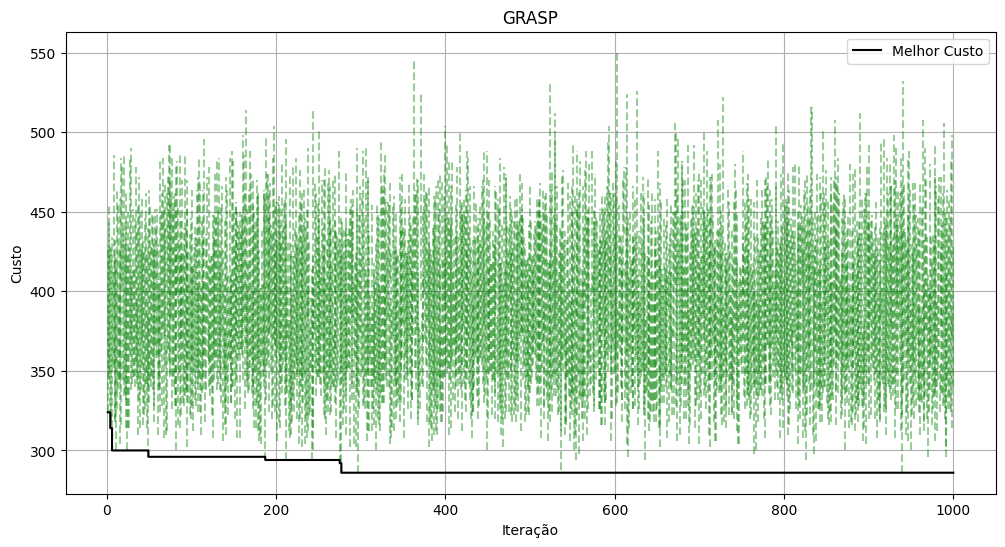

In [7]:
epochs = range(1, len(epoch_costs) + 1)
greedy_costs = [data[0] for data in epoch_costs]
improved_costs = [data[1] for data in epoch_costs]
best_costs_so_far = [data[2] for data in epoch_costs]

plt.figure(figsize=(12, 6))

for epoch, (greedy_cost, improved_cost, _) in zip(epochs, epoch_costs):
    plt.vlines(epoch, ymin=improved_cost, ymax=greedy_cost, color='green', linestyle='--', alpha=0.4)
plt.step(epochs, best_costs_so_far, color='black', linestyle='-', where='post', label='Melhor Custo')

plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('GRASP')
plt.legend()
plt.grid(True)
plt.show()